# Knapsack problem

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('..')

from src import qubo, data, ising, brute_force, cplex
import numpy as np
from time import time
import matplotlib.pyplot as plt

## Select the problem

In [5]:
kp_type = 'small'
problems = data.load(kp_type, path='../kp_instances')
problem = problems[12]
problem

{'C': 22,
 'n': 8,
 'weights': [16, 14, 15, 9, 7, 9, 4, 5],
 'profits': [13, 12, 12, 9, 9, 6, 1, 4]}

# Classical solvers

## Brute force

In [6]:
bf_sol = None
if kp_type == 'large':
    print('I CANNOT DO THAT SIR!')
else:
    max_ram = 40E9
    st = time()
    bf_sol = brute_force.kp_brute_force(problem['profits'], problem['weights'], problem['C'], max_ram)
    et = time()
    bf_time = et - st
bf_sol

Number of threads: 15
Max samples: 31250000
Number of steps: 1


100%|██████████| 1/1 [00:00<00:00, 27.56it/s]


{'profit': array([22]), 'cost': array([21]), 'combo': [array([3, 4, 7])]}

In [7]:
# get the solution which also minimises the cost
best_indices = np.flatnonzero(bf_sol['cost'] == bf_sol['cost'].min())

print('Best solution(s) found by brute force:')
print('Profit:', bf_sol['profit'][best_indices[0]])
print('Cost:', bf_sol['cost'][best_indices[0]])
print('Combo(s):', [bf_sol['combo'][i] for i in best_indices])

print('============')
print('  RUN INFO  ')
print('============')
print(f'Run time: {bf_time :.4f} s')


Best solution(s) found by brute force:
Profit: 22
Cost: 21
Combo(s): [array([3, 4, 7])]
  RUN INFO  
Run time: 0.0405 s


## CPlex

In [8]:
cplex_sol = cplex.cplex_kp_solver(problem['profits'], problem['weights'], problem['C'], problem['n'])
print('Solution found by CPLEX:')
print('Profit:', cplex_sol['profit'])
print('Cost:', cplex_sol['cost'])
print('Combo:', np.flatnonzero(cplex_sol['combo']))

print('===========================')
print('         RUN INFO          ')
print('===========================')
cplex_time = cplex_sol['runtime']
print(f'Run time: {cplex_time:.4f} s')

Knapsack problem instance as a BLIP
Problem name: KP_0008_00022

Maximize
  13*x_0 + 12*x_1 + 12*x_2 + 9*x_3 + 9*x_4 + 6*x_5 + x_6 + 4*x_7

Subject to
  Linear constraints (1)
    16*x_0 + 14*x_1 + 15*x_2 + 9*x_3 + 7*x_4 + 9*x_5 + 4*x_6 + 5*x_7
    <= 22  'The total weight of the knapsack must not exceed 22'

  Binary variables (8)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7




Solution found by CPLEX:
Profit: 22.0
Cost: 21
Combo: [3 4 7]
         RUN INFO          
Run time: 0.0241 s


# Quantum solvers

## Exact diagonalization

In [10]:
# get the qubo matrix
LAMBDA = max(problem['profits'])*1.1
st = time()
Q = qubo.get_Q(problem['weights'], problem['profits'], problem['C'], LAMBDA)
t1 = time() - st

# embed the qubo matrix into an hamiltonian
st = time()
h, J, offset = ising.qubo_to_hamiltonian(Q)

'''
offset, h, J_arr = qubo_to_ising_couplings(Q).values()

J_arr = {(i, k) : J_arr[i, k] *5 for i in range(Q.shape[0]) for k in range(i+1, Q.shape[0])}
J = J_arr.copy()

for (i, k), v in J_arr.items():
    J[k, i] = v
'''
t2 = time() - st

if kp_type != 'small':
    print('I CANNOT DO THAT SIR!')
else:
    # get the diagonal of the hamiltonian
    st = time()
    diag = ising.construct_quantum_hamiltonian_diag(h, J, offset)
    t3 = time() - st
    st = time()
    diag_sol = np.argmin(diag)
    diag_sol_bits = (~brute_force.toBitstrings(diag_sol, Q.shape[0])).astype(int)
    t4 = time() - st
    cost = diag_sol_bits[:problem['n']].dot(problem['weights'])
    profit = diag_sol_bits[:problem['n']].dot(problem['profits'])
    ed_time = t1 + t2 + t3 + t4
    print('Solution found by diagonalising the Hamiltonian:')
    print('Profit:', profit)
    print('Cost:', cost, f" (but cost was: {problem['C']}" if cost > problem['C'] else '')
    print('Combo:', np.flatnonzero(diag_sol_bits[:problem['n']]))
    print('============')
    print('  RUN INFO  ')
    print('============')
    print(f'Time for QUBO: {t1:.4f} s')
    print(f'Time for Hamiltonian coeffs: {t2:.4f} s')
    print(f'Time for Hamiltonian: {t3:.4f} s')
    print(f'Time for diagonalisation: {t4:.4f} s')
    print(f'Total time: {ed_time:.4f} s')

Solution found by diagonalising the Hamiltonian:
Profit: 22
Cost: 21 
Combo: [3 4 7]
  RUN INFO  
Time for QUBO: 0.0002 s
Time for Hamiltonian coeffs: 0.0003 s
Time for Hamiltonian: 0.0422 s
Time for diagonalisation: 0.0001 s
Total time: 0.0429 s


## QAOA in Qiskit

In [11]:
from qiskit.result import QuasiDistribution

from qiskit_algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA

from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import QAOAAnsatz
from qiskit.primitives import Sampler
from qiskit.quantum_info import Statevector

def calc_cost_and_constraint(profits, weights, solution, C):
    assert len(profits) == len(weights)
    s = len(profits)

    total_cost = sum(profits[i] * solution[i] for i in range(s))
    print("Optimum value of profit function from ED = ",total_cost)

    slack = sum((2**i) * solution[s + i] for i in range(len(solution) - (s + 1)))
    slack += (C + 1 - 2**(len(solution) - s - 1)) * solution[-1]
    print("Total value of slack variable = ", slack)

    total_weight = sum(weights[k] * solution[k] for k in range(s))
    if (total_weight <= C):
       print("Total weight less than given constraint")
    else:
       print("Weight constraint not satisfied; wrong solution")

/tmp/ipykernel_1413187/1193776531.py:4: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA


In [12]:

# get the qubo matrix
LAMBDA = max(problem['profits']) + 2
Q = qubo.get_Q(problem['weights'], problem['profits'], problem['C'], LAMBDA)

# embed the qubo matrix into an hamiltonian
h, J, offset = ising.qubo_to_hamiltonian(Q)

st = time()
H = ising.construct_quantum_hamiltonian_qiskit(h, J, offset)
t1 = time() - st

In [13]:
result = None

if kp_type == 'large':
    print('I CANNOT DO THAT SIR!')
else:
    sampler = Sampler()
    algorithm_globals.random_seed = 10598

    optimizer = COBYLA()
    qaoa = QAOA(sampler, optimizer, reps=2)

    result = qaoa.compute_minimum_eigenvalue(H)

/home/ubuntu/data/Tensor-Network-Hackathon-2024/tn_knapsack_optimization/.kp_venv/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


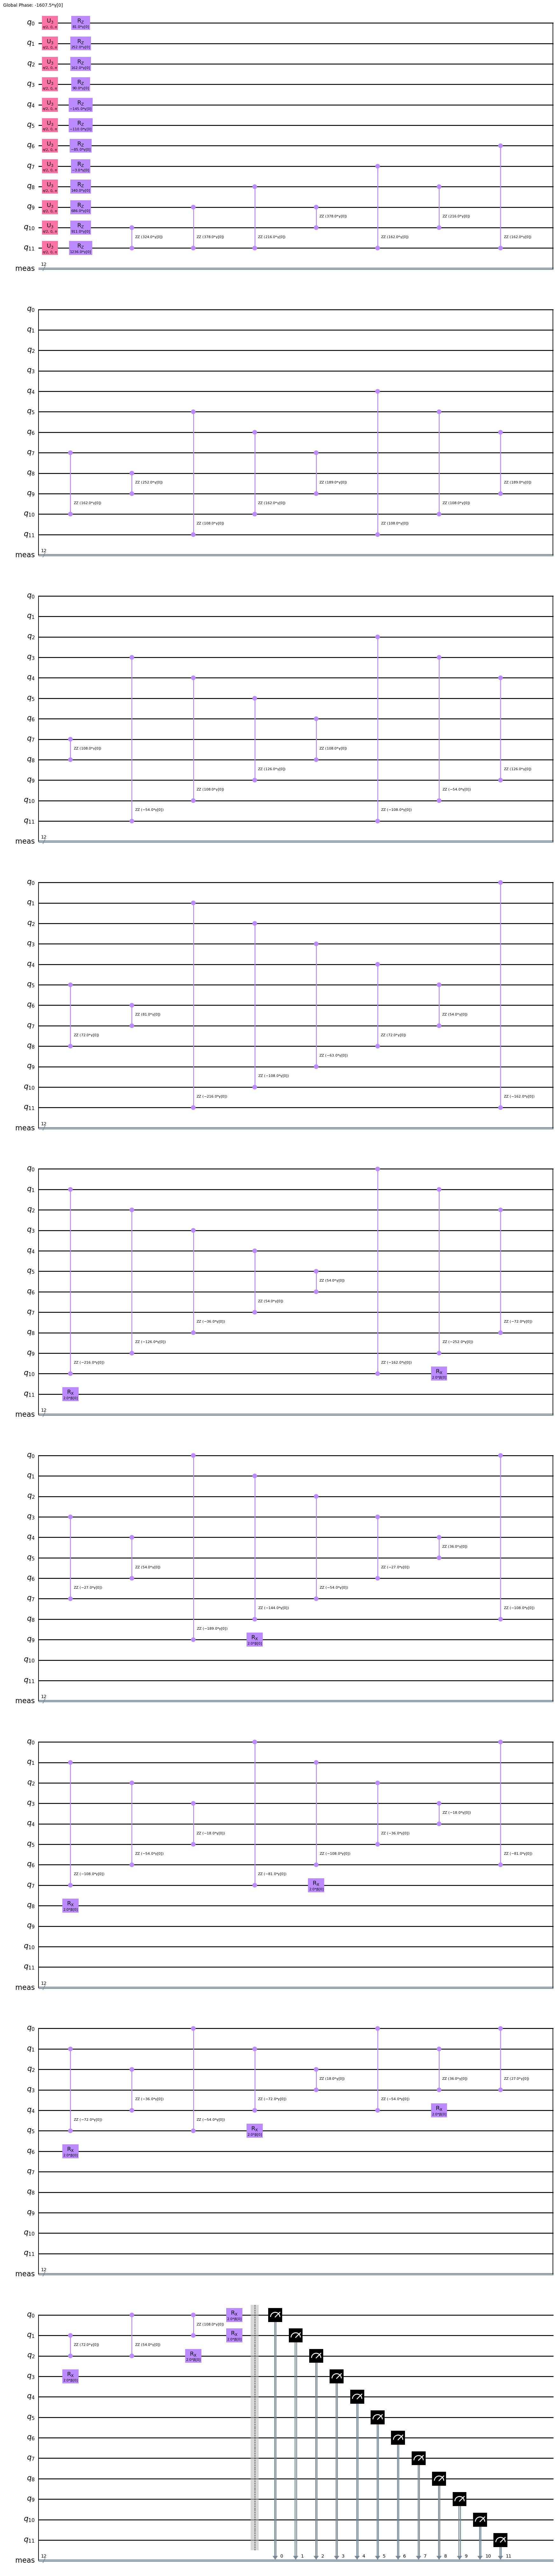

In [40]:
result.optimal_circuit.decompose().decompose().draw('mpl')

In [14]:
# get the solution
qaoa_qk_sol = result.best_measurement['bitstring']
qaoa_qk_sol_bits = np.logical_not(np.array([int(bit) for bit in qaoa_qk_sol])).astype(int)
print('Solution found by QAOA:')
print('Profit:', qaoa_qk_sol_bits[:problem['n']].dot(problem['profits']))
print('Cost:', qaoa_qk_sol_bits[:problem['n']].dot(problem['weights']))
print('Combo:', np.flatnonzero(qaoa_qk_sol_bits[:problem['n']]))
print('Slack:', qaoa_qk_sol_bits[problem['n']:])
calc_cost_and_constraint(problem['profits'], problem['weights'], qaoa_qk_sol_bits, problem['C'])
print('============')
print('  RUN INFO  ')
print('============')
qubo_qk_time = result.optimizer_time + t1
print(f'Time for Hamiltonian: {t1:.4f} s')
print(f'Time for QAOA: {result.optimizer_time:.4f} s')
print(f'Total time: {qubo_qk_time:.4f} s')

Solution found by QAOA:
Profit: 22
Cost: 21
Combo: [3 4 7]
Slack: [0 1 1 1 1]
Optimum value of profit function from ED =  22
Total value of slack variable =  21
Total weight less than given constraint
  RUN INFO  
Time for Hamiltonian: 0.0028 s
Time for QAOA: 46.2766 s
Total time: 46.2795 s


## QAOA in Matcha Tea